# Hot Hand Final Project

## Data Exploration

** Chip ** 11/4/16

In [58]:
## Load necessary libraries
import numpy as np
import pandas as pd
import scipy as sp
from sklearn import linear_model
import matplotlib.pyplot as plt
from sklearn import discriminant_analysis
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn import tree
from sklearn import ensemble
from sklearn.cross_validation import KFold
import StringIO
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [59]:
## Read in data
shot_logs_full = pd.read_csv('shot_logs.csv')
shot_logs_full.columns = map(str.lower, shot_logs_full.columns)

# Preview data
print 'Number of variables:', np.shape(shot_logs_full)[1]
print 'Variable names:', shot_logs_full.columns.values
print 'Number of observations/shots:', np.shape(shot_logs_full)[0]
shot_logs_full.head()

Number of variables: 21
Variable names: ['game_id' 'matchup' 'location' 'w' 'final_margin' 'shot_number' 'period'
 'game_clock' 'shot_clock' 'dribbles' 'touch_time' 'shot_dist' 'pts_type'
 'shot_result' 'closest_defender' 'closest_defender_player_id'
 'close_def_dist' 'fgm' 'pts' 'player_name' 'player_id']
Number of observations/shots: 128069


,game_id,matchup,location,w,final_margin,shot_number,period,game_clock,shot_clock,dribbles,...,shot_dist,pts_type,shot_result,closest_defender,closest_defender_player_id,close_def_dist,fgm,pts,player_name,player_id
0,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,1,1,1:09,10.8,2,...,7.7,2,made,"Anderson, Alan",101187,1.3,1,2,brian roberts,203148
1,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,2,1,0:14,3.4,0,...,28.2,3,missed,"Bogdanovic, Bojan",202711,6.1,0,0,brian roberts,203148
2,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,3,1,0:00,NaN,3,...,10.1,2,missed,"Bogdanovic, Bojan",202711,0.9,0,0,brian roberts,203148
3,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,4,2,11:47,10.3,2,...,17.2,2,missed,"Brown, Markel",203900,3.4,0,0,brian roberts,203148
4,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,5,2,10:34,10.9,2,...,3.7,2,missed,"Young, Thaddeus",201152,1.1,0,0,brian roberts,203148


Number of unique player-game combinations where the player took a shot: 14343
Mean number of shots per game per player (given they have taken one): 8.92902461131


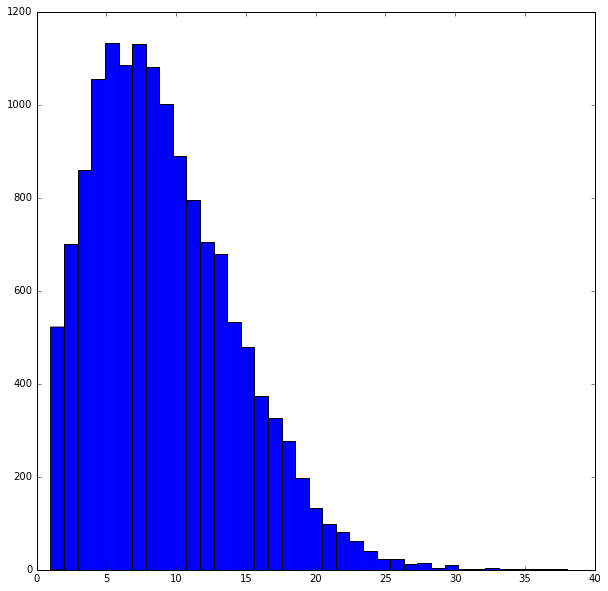

In [60]:
## Determine players with min number of shots taken per game to be included in analysis

# Group observations by unique values of player_id and game_id
gp = shot_logs_full.groupby(['player_id', 'game_id'])

# Create array that has shots per game for each unique value of player_id and game_id 
# (computationally expensive/inefficient, lmk if you have other ideas)
shots_per_game_per_player = []
for g in gp.groups.items():
    shots_per_game_per_player.append(np.shape(shot_logs_full.loc[g[1]])[0])
    
print 'Number of unique player-game combinations where the player took a shot:', len(shots_per_game_per_player)
print 'Mean number of shots per game per player (given they have taken one):', np.mean(shots_per_game_per_player)

# Histogram of number of shots per player per game
fig = plt.figure(figsize=(10, 10))
ax1 = fig.add_subplot(111)
ax1 = plt.hist(shots_per_game_per_player, bins = 38)
plt.show()

** Comment: **
Given the above information, I would drop all players with less than **5** (maybe 4) shots per game. This is substantially below the mean (above) and the median (8). Intuitively, this seems legit, i.e., I think we can consider the prior belief that it is incredibly unlikely for players who have taken 4 or less shots to have the hot hand. Open to other interpretation though!

In [65]:
## Create new dataframe with only player-game combos where each player had more than 4 shots taken

# Crate holding array
df_list = []

# Create array that has shots per game for each unique value of player_id and game_id 
# (again, computationally expensive/inefficient, lmk if you have other ideas)
for g in gp.groups.items():
    if (np.shape(shot_logs_full.loc[g[1]])[0] > 4):
        df_list.append(shot_logs_full.loc[g[1]])
        
# Concatenate df's that meet 5+ shot criteria
shot_logs_reduced = pd.concat(df_list)

# Preview reduced logs
print 'Number of observations/shots:', np.shape(shot_logs_reduced)[0]
shot_logs_reduced.head()

Number of observations/shots: 119341


,game_id,matchup,location,w,final_margin,shot_number,period,game_clock,shot_clock,dribbles,...,shot_dist,pts_type,shot_result,closest_defender,closest_defender_player_id,close_def_dist,fgm,pts,player_name,player_id
28621,21400054,"NOV 04, 2014 - NOP vs. CHA",H,W,9,1,1,2:29,22.1,0,...,26.2,3,made,"Roberts, Brian",203148,4.4,1,3,ryan anderson,201583
28622,21400054,"NOV 04, 2014 - NOP vs. CHA",H,W,9,2,2,11:19,5.8,2,...,18.2,2,made,"Zeller, Cody",203469,6.1,1,2,ryan anderson,201583
28623,21400054,"NOV 04, 2014 - NOP vs. CHA",H,W,9,3,2,10:51,10.2,2,...,20.4,2,missed,"Maxiell, Jason",101131,5.7,0,0,ryan anderson,201583
28624,21400054,"NOV 04, 2014 - NOP vs. CHA",H,W,9,4,2,8:21,24.0,0,...,2.5,2,made,"Zeller, Cody",203469,2.6,1,2,ryan anderson,201583
28625,21400054,"NOV 04, 2014 - NOP vs. CHA",H,W,9,5,2,7:59,16.0,0,...,26.0,3,missed,"Zeller, Cody",203469,6.5,0,0,ryan anderson,201583
